# Prueba de evaluación continua 2
## Parte 1: Board de 4chan
***
- Autor: Juan A. García Cuevas
- Fecha: 16/10/2016
***

# Enunciado
En esta primera parte trabajaremos con el API REST de 4chan: https://github.com/4chan/4chan-API (es conveniente tratar de comprender los campos que devuelve el JSON antes de comenzar, siguiendo el ejemplo de clase)
Se pide lo siguiente:
- Obtener una muestra de dos boards de 4chan, sacando una instantánea concreta (todas las páginas de cada board). Solo es necesario obtener la información requerida para los puntos siguientes, no es necesario procesar todo.
- Contrastar diferencias en la media de respuestas por post en los dos boards elegidos.
- Obtener la distribución del tamaño de las imágenes en los posts de uno de los boards.

# Resolución

In [1]:
# Importamos algunas librerías
import requests as rq
import json
import pandas as pd
import numpy as np
import seaborn as sns
from time import time 
from ipykernel import kernelapp as app

# Para que los gráficos se muestren en el notebook
import matplotlib.pyplot as plt 
%matplotlib inline

# Descarga de información de internet

La url principal del API de 4chan es [https://a.4cdn.org/boards.json](https://a.4cdn.org/boards.json).

El JSON que devuelve como respuesta contiene una colección de boards, y para cada uno de ellos datos como: *titte, meta_description, pages*...

In [2]:
# Descargamos de internet la url que propone la página web del API, en formato JSON
query = rq.get('https://a.4cdn.org/boards.json')

# Parseamos el JSON
boards = json.loads(query.text) 

# Mostramos información del JSON
print '\n*** Nº de boards:', len(boards['boards'])
print '\n*** Borad nº1:\n', boards['boards'][1]
print '\n*** Borad nº2:\n', boards['boards'][2]


*** Nº de boards: 71

*** Borad nº1:
{u'max_webm_duration': 120, u'meta_description': u"&quot;/a/ - Anime &amp; Manga&quot; is 4chan's imageboard dedicated to the discussion of Japanese animation and manga.", u'cooldowns': {u'images': 60, u'threads': 600, u'replies': 60}, u'title': u'Anime & Manga', u'spoilers': 1, u'is_archived': 1, u'max_comment_chars': 2000, u'ws_board': 1, u'max_filesize': 4194304, u'custom_spoilers': 1, u'board': u'a', u'max_webm_filesize': 3145728, u'per_page': 15, u'bump_limit': 500, u'image_limit': 250, u'pages': 10}

*** Borad nº2:
{u'max_webm_duration': 120, u'meta_description': u"&quot;/aco/ - Adult Cartoons&quot; is 4chan's imageboard for posting western-styled adult cartoon artwork.", u'cooldowns': {u'images': 30, u'threads': 600, u'replies': 60}, u'title': u'Adult Cartoons', u'is_archived': 1, u'max_comment_chars': 2000, u'ws_board': 0, u'max_filesize': 4194304, u'board': u'aco', u'max_webm_filesize': 3145728, u'per_page': 15, u'bump_limit': 300, u'image

In [3]:
# Creamos un dataframe con los datos descargados y parseados
df = pd.DataFrame(columns=["title", "meta_description", "pages"])
for board in boards["boards"]:
    title = board["title"]
    metadesc = board["meta_description"]
    page = int(board["pages"])
    df.loc[board["board"]] = [title, metadesc,  page] 

# Mostramos información del dataframe
print '\n*** Lista de boards:', df["title"].unique()
print '\n*** Dimensiones del data frame:', df.shape
print '\n*** Muestra del data frame:'
df.head()


*** Lista de boards: [u'3DCG' u'Anime & Manga' u'Adult Cartoons' u'Advice' u'Animals & Nature'
 u'Alternative Sports & Wrestling' u'Random' u'Business & Finance'
 u'Anime/Cute' u'Cosplay & EGL' u'Food & Cooking' u'Cute/Male'
 u'Comics & Cartoons' u'Hentai/Alternative' u'Do It Yourself' u'Ecchi'
 u'Flash' u'Fashion' u'Fitness' u'Technology' u'Graphic Design'
 u'Adult GIF' u'Hentai' u'Hardcore' u'History & Humanities' u'Handsome Men'
 u'High Resolution' u'Oekaki' u'Artwork/Critique' u'International'
 u'Otaku Culture' u'Weapons' u'LGBT' u'Literature' u'Mecha' u'Pony'
 u'Music' u'Transportation' u'Current News' u'Auto' u'Outdoors'
 u'Photography' u'Papercraft & Origami' u'Politically Incorrect'
 u'Question & Answer' u'Quests' u'Adult Requests' u'ROBOT9001'
 u'Sexy Beautiful Women' u'Shit 4chan Says' u'Science & Math'
 u'Cams & Meetups' u'Sports' u'Torrents' u'Traditional Games' u'Toys'
 u'Off-Topic' u'Travel' u'Television & Film' u'Yuri' u'Video Games'
 u'Video Game Generals' u'Very Impor

,title,meta_description,pages
3,3DCG,&quot;/3/ - 3DCG&quot; is 4chan's board for 3D...,10.0
a,Anime & Manga,&quot;/a/ - Anime &amp; Manga&quot; is 4chan's...,10.0
aco,Adult Cartoons,&quot;/aco/ - Adult Cartoons&quot; is 4chan's ...,10.0
adv,Advice,&quot;/adv/ - Advice&quot; is 4chan's board fo...,10.0
an,Animals & Nature,&quot;/an/ - Animals &amp; Nature&quot; is 4ch...,10.0


Cada board tiene varias páginas con url's al estilo de este ejemplo: [https://a.4cdn.org/an/1.json](https://a.4cdn.org/an/1.json), donde 'an' es el identificador de board y '1' el número de página.

Cada board contiene una colecciṕn de threads, cada thread una colección de posts con datos como: *no, replies, fsize, ext*...

In [4]:
# Creamos una función para descargar las páginas de un board de 4chan
def downloadBoardPages(board, name):
    print '- Título.......:', board['title']
    print '- Nº de páginas:', board['pages']

    # Crea el dataframe donde almacenar los datos
    df_result = pd.DataFrame(columns=['id', 'idPost', 'replies', 'fsize', 'ext'])

    # Toma el tiempo al inicio del proceso de descarga y parseo
    time_start = time()

    # Obtiene el número de páginas del board
    num_pages = board['pages'].astype(np.int32) 

    # Descarga las páginas y parsea su contenido
    count_threads = 0
    count_posts = 0
    for p in range(1, num_pages + 1):
        # Construye la url de la página del board
        url = 'https://a.4cdn.org/' + name + '/'+ str(p) +'.json'
        print '*** Descargando página', p, ':', url, '...'
        # Descarga el contenido de la url
        url_content = rq.get(url)
        # Transforma la información en un objeto JSON
        obj_json = json.loads(url_content.text)
        # Recorre los hilos del objeto
        #print '   - Nº de Hilos:', len(obj_json['threads'])
        for hilo in obj_json['threads']:
            #print '   - Hilo...'
            count_threads = count_threads + 1
            # Recorre los post del objeto
            #print '      - Nº de Posts:', len(hilo['posts'])
            for post in hilo['posts']:
                count_posts = count_posts + 1
                id_post = post['no']
                replies = 0
                fsize = 0
                ext = ''
                if ('replies' in post):
                    replies = int(post['replies'])
                if ('fsize' in post):
                    fsize = float(post['fsize'])
                if ('ext' in post):
                    ext = post['ext'] 
                df_result.loc[id_post] = [str(count_threads), id_post, replies, fsize, ext]
                #print '-', str(id), id_post, replies, fsize, ext
    
    # Toma el tiempo al final del proceso de descarga y parseo, y muestra el tiempo total
    time_end = time() 
    time_exe = time_end - time_start
    print '- Tiempo de descarga:', round(time_exe, 3), 'sg.'   

    # Retorna el dataframe resultante
    return  df_result  

In [5]:
# Seleccionaremos los board de tecnología (g - Technology) y animales y naturaleza (an - Animals & Nature)
board_tec = df.loc['g']
board_nat = df.loc['an']

### Descarga del board de animales y naturaleza (an)

In [6]:
# Descargamos las páginas del board de animales y naturaleza
df_nat = downloadBoardPages(board_nat, 'an')

- Título.......: Animals & Nature
- Nº de páginas: 10.0
*** Descargando página 1 : https://a.4cdn.org/an/1.json ...
*** Descargando página 2 : https://a.4cdn.org/an/2.json ...
*** Descargando página 3 : https://a.4cdn.org/an/3.json ...
*** Descargando página 4 : https://a.4cdn.org/an/4.json ...
*** Descargando página 5 : https://a.4cdn.org/an/5.json ...
*** Descargando página 6 : https://a.4cdn.org/an/6.json ...
*** Descargando página 7 : https://a.4cdn.org/an/7.json ...
*** Descargando página 8 : https://a.4cdn.org/an/8.json ...
*** Descargando página 9 : https://a.4cdn.org/an/9.json ...
*** Descargando página 10 : https://a.4cdn.org/an/10.json ...
- Tiempo de descarga: 7.539 sg.


In [7]:
# Mostramos información del dataframe
print 'Dimensiones....:', df_nat.shape
print 'Número de hilos:', len(df_nat['id'].unique())
df_nat.head()

Dimensiones....: (789, 5)
Número de hilos: 150


,id,idPost,replies,fsize,ext
2248564,1,2248564.0,7.0,67517.0,.jpg
2248575,1,2248575.0,0.0,0.0,
2248577,1,2248577.0,0.0,0.0,
2248578,1,2248578.0,0.0,0.0,
2248580,1,2248580.0,0.0,0.0,


### Descarga del board de tecnología (g)

In [8]:
# Descargamos las páginas del board de tecnología
df_tec = downloadBoardPages(board_tec, 'g')

- Título.......: Technology
- Nº de páginas: 10.0
*** Descargando página 1 : https://a.4cdn.org/g/1.json ...
*** Descargando página 2 : https://a.4cdn.org/g/2.json ...
*** Descargando página 3 : https://a.4cdn.org/g/3.json ...
*** Descargando página 4 : https://a.4cdn.org/g/4.json ...
*** Descargando página 5 : https://a.4cdn.org/g/5.json ...
*** Descargando página 6 : https://a.4cdn.org/g/6.json ...
*** Descargando página 7 : https://a.4cdn.org/g/7.json ...
*** Descargando página 8 : https://a.4cdn.org/g/8.json ...
*** Descargando página 9 : https://a.4cdn.org/g/9.json ...
*** Descargando página 10 : https://a.4cdn.org/g/10.json ...
- Tiempo de descarga: 9.155 sg.


In [9]:
# Mostramos información del dataframe
print 'Dimensiones....:', df_tec.shape
print 'Número de hilos:', len(df_tec['id'].unique())
df_tec.head()

Dimensiones....: (809, 5)
Número de hilos: 150


,id,idPost,replies,fsize,ext
51971506,1,51971506.0,0.0,299699.0,.png
57202590,2,57202590.0,17.0,1760178.0,.png
57203238,2,57203238.0,0.0,1318798.0,.png
57203272,2,57203272.0,0.0,0.0,
57203276,2,57203276.0,0.0,0.0,


# Contraste de la media de respuestas por post

El primer post de cada thread contiene el número de respuestas, mientras que los siguientes (las respuestas) tienen el campo resplies a 0. Por ello, nos quedaremos únicamente con el primer post de cada thread, eliminando los que tienen replies a 0. 

In [10]:
# Board: Animales y naturaleza
df_nat_rep = df_nat['replies']
num_post_total = len(df_nat_rep)
df_nat_aux = df_nat[df_nat['replies'] > 0]
df_nat_rep = df_nat_aux['replies']
num_post_0 = len(df_nat_rep)
print '\n*** Board: Animales y naturaleza:'
print '- Número total de post...............:', num_post_total
print '- Número de post sin respuesta.......:', num_post_0
print '- Número de post con alguna respuesta:', (num_post_total - num_post_0)

# Board: Tecnología
df_tec_rep = df_tec['replies']
num_post_total = len(df_tec_rep)
df_tec_aux = df_tec[df_tec['replies'] > 0]
df_tec_rep = df_tec_aux['replies']
num_post_0 = len(df_tec_rep)
print '\n*** Board: Tecnología:'
print '- Número total de post...............:', num_post_total
print '- Número de post sin respuesta.......:', num_post_0
print '- Número de post con alguna respuesta:', (num_post_total - num_post_0)


*** Board: Animales y naturaleza:
- Número total de post...............: 789
- Número de post sin respuesta.......: 144
- Número de post con alguna respuesta: 645

*** Board: Tecnología:
- Número total de post...............: 809
- Número de post sin respuesta.......: 147
- Número de post con alguna respuesta: 662


In [11]:
# Obtenemos las medias de respuestas por post de cada board
df_nat_mean = df_nat_rep.mean()
df_tec_mean = df_tec_rep.mean()
print '- La media de respuestas por post en el board de animales y naturaleza es:', df_nat_mean
print '- La media de respuestas por post en el board de tecnología es...........:', df_tec_mean

- La media de respuestas por post en el board de animales y naturaleza es: 38.5138888889
- La media de respuestas por post en el board de tecnología es...........: 52.5238095238


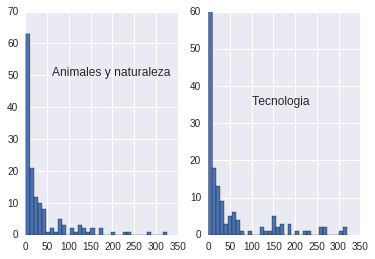

In [12]:
# Mostramos un histograma de cada board con todos los post
plt.figure(1)

plt.subplot(121)
plt.hist(df_nat_rep, bins=35)
plt.text(60, 50, 'Animales y naturaleza', fontsize=12)

plt.subplot(122)
plt.hist(df_tec_rep, bins=35)
plt.text(100, 35, 'Tecnologia',fontsize=12)

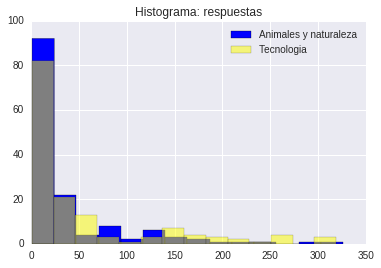

In [13]:
# Y ahora mostramos los histogramas superpuestos
plt.hist(df_nat_rep, bins=14, histtype='bar', color='blue', label='Animales y naturaleza')
plt.hist(df_tec_rep, bins=14, histtype='bar', color='yellow', label='Tecnologia', alpha=0.5)
plt.title('Histograma: respuestas')
plt.legend()
plt.show()

Podemos ver que los post con menos de 25 respuestas son significativamente más numerosos en ambos boards, y relativamente numerosos entre las 25 y 50 respuestas.

# Distribución del tamaño de las imágenes en los posts de un board

Vamos a obtener la distribución de las imágenes de los post del board de animales y naturaleza.

In [14]:
# Obtenemos las distintas extensiones de ficheros
print df_nat['ext'].unique()

[u'.jpg' '' u'.png' u'.gif']


In [15]:
# Eliminamos los post que no contienen imágenes (ext) y/o los que el tamaño (size) es 0
img_nat = df_nat
img_nat = img_nat[img_nat['fsize'] > 0]
#img_nat = img_nat[img_nat['ext'] != '.webm']
img_nat.dropna(subset=['ext'])

# Mostramos información del dataframe resultante
print img_nat.shape
img_nat.head()

(289, 5)


,id,idPost,replies,fsize,ext
2248564,1,2248564.0,7.0,67517.0,.jpg
2241247,2,2241247.0,78.0,666249.0,.jpg
2248583,2,2248583.0,0.0,18368.0,.jpg
2246324,3,2246324.0,34.0,49542.0,.jpg
2248581,3,2248581.0,0.0,10541.0,.jpg


In [16]:
# Comprobamos que ahora el dataset solo contiene imágenes
print img_nat['ext'].unique()

[u'.jpg' u'.png' u'.gif']


<class 'matplotlib.axes._subplots.AxesSubplot'>


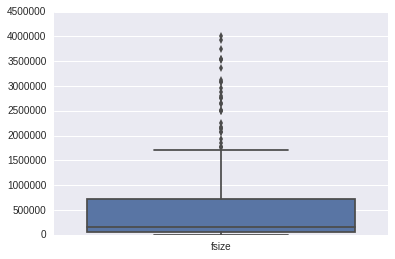

In [17]:
# Mostramos el diagrama boxplot
ax = sns.boxplot(data=img_nat[['fsize']]) 
print type(ax)

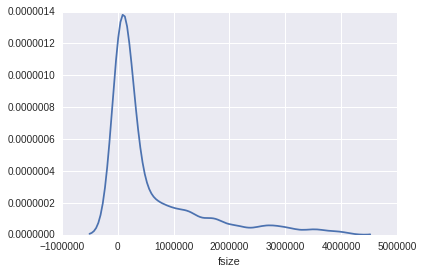

In [18]:
# Mostramos ahora un displot de los datos
sns.distplot(img_nat['fsize'], hist=False, rug=False) 

In [19]:
# Hacemos también un test de normalidad de la distribución
from scipy.stats.mstats import normaltest  
_, ntest = normaltest(img_nat["fsize"])
print ntest

3.58417586529e-27


En el boxplot podemos ver numerosos outliers, y en distplot que la distribución no es de tipo normal, sino que tiene una cola de valores muy pronunciada a la derecha.

Podemos concluir que la nistribuciçon no sigle la normal..

Las imágenes son mayoritariamente de pequeño tamaño.